# Introduction

Hello! My name is Wenjun (Wendy) Shao, Fellow at Insight Data Science. I worked with a mobile advertising company (stealth mode) while at the program. I helped them to figure out the major factors that influenced the click-through-rate (CTR) for ads. I found that mobile platform and geo-location had huge impact on CTR. I also implemented the collaborative filtering algorithm that gives recommendations of new ads for each app based on their performance in the past.

Here's a summary of the key analyses I did for the project. For more detailed information, please visit my github:
github.com/hellowendy

To begin with, here's the list of modules I have used in the analysis:

In [2]:
from elasticsearch import Elasticsearch
import json
import requests

import eslogin

import datetime
import time

import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import sklearn as sklearn

import plotly.plotly as py
from plotly.graph_objs import *

%matplotlib inline
mpl.style.use('ggplot')

# Query data from ElasticSearch

connect to the cluster on ElasticSearch:

In [3]:
es = Elasticsearch([{'host': eslogin.host, 'port': eslogin.port}],http_auth=(eslogin.user,eslogin.password))

I got the count umber of events for each event type and plot them in log10 scale as below. The clicks of ads are rare events. The number of installs is even smaller.

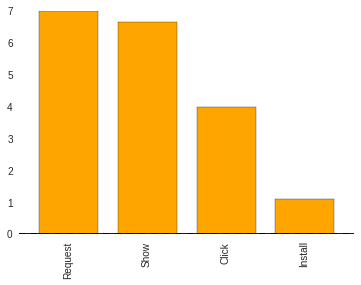

In [475]:
tmp = pd.Series(np.log10([9884550,4508030,9719,13]),index=['Request','Show','Click','Install'])
plt.figure()
tmp.plot(kind='bar',color='orange')
plt.axhline(0,color='k')

Count the number of valid clicks so far

In [22]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

9159

In [69]:
clicks = es.search(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}}, size = 9159)

In [70]:
clicks_df = pd.DataFrame([datum['_source'] for datum in clicks['hits']['hits']])

In [71]:
clicks_df.shape

(9159, 46)

Examine each column - each potential feature

In [73]:
len(clicks_df.columns.values)

46

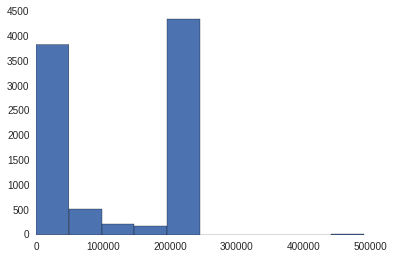

In [367]:
#plot_ind = [0, 2, 5, 8, 12, 15, 18, 21, 27, 28, 31, 32, 34, 37, 44, 45]

clicks_df['ernc'][clicks_df['ernc'].apply(lambda x:x < 500000)].hist()

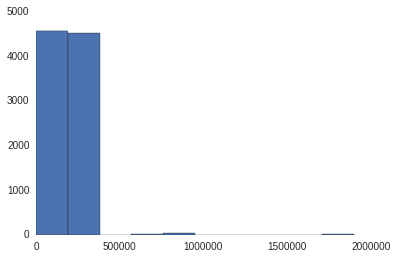

In [397]:
clicks_df['dp'].hist()

Make subset of the dataframe excluding the features that do not make sense for now OR not seem to be important OR too many NAN...

Remove duplicated events:

In [218]:
clicks_uniq = clicks_df.loc[np.where(np.unique(clicks_df['created_at']))[0], :]

Check the number of NaN in each column:

#Dealing with missing data

In [16]:
pd.notnull(clicks_df_small['rgn']).sum()

2840

Discard the data with missing value for the first model. I have also included these data for latter analysis.

In [21]:
clicks_df_small_dropna['dt'].value_counts()

android    1004
iphone       65
ipad         13
dtype: int64

# Cleaning the data by parsing each column

remove version number in the browser information:

In [47]:
def get_browser(br_vs):
    return br_vs.split()[0]
clicks_df_small_dropna_parse['br'] = clicks_df_small_dropna_parse['br'].apply(get_browser)

In [26]:
clicks_df_small_dropna_parse['br'].value_counts()

Android    611
Chrome     411
iPhone      48
...
Android    611
Chrome     411
iPhone      48
iPad        12
Length: 4, dtype: int64

parsing date and time information:

In [48]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
clicks_df_small_dropna_parse['created_at'] = clicks_df_small_dropna_parse['created_at'].apply(get_date)

In [49]:
clicks_df_small_dropna_parse['date'] = clicks_df_small_dropna_parse['created_at'].apply(datetime.datetime.date)

In [51]:
def get_time_of_day(datetimeObj):
    hour = datetimeObj.hour
    result = 'Evening'
    if hour < 12:
        result = 'Morning'
    elif hour < 16:
        result = 'Afternoon'
    return result
clicks_df_small_dropna_parse['time'] = clicks_df_small_dropna_parse['created_at'].apply(get_time_of_day)

In [33]:
clicks_df_small_dropna_parse['time'].value_counts()

Evening      429
Morning      419
Afternoon    234
dtype: int64

Plot the difference in the number of click events among three time period (mornings, afternoons, or evenings):

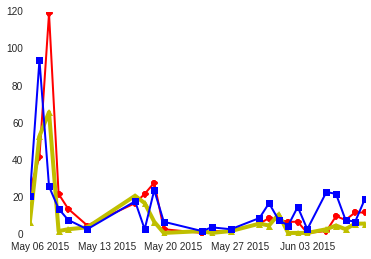

In [52]:
morning = clicks_df_small_dropna_parse.loc[clicks_df_small_dropna_parse['time'] == 'Morning',]['date'].value_counts().sort_index()
afternoon = clicks_df_small_dropna_parse.loc[clicks_df_small_dropna_parse['time'] == 'Afternoon',]['date'].value_counts().sort_index()
evening = clicks_df_small_dropna_parse.loc[clicks_df_small_dropna_parse['time'] == 'Evening',]['date'].value_counts().sort_index()
merge = pd.concat([morning, afternoon, evening], axis=1, join='inner')
merge.columns = ['morning', 'afternoon', 'evening']
styles = ['ro-','y^-','bs-']
linewidths = [2, 4, 2]
fig, ax = plt.subplots()
for col, style, lw in zip(merge.columns, styles, linewidths):
    merge[col].plot(style=style, lw=lw, ax=ax)

Need to add ads and app type/category information. Later...

#Prepare the first but small positive set (training + validation + test)

Here I used 880 from May as training set, and use 202 from June as validation/test set, because I wanted to use the past data to predict future events. However, I also randomly shuffled the data regardless the date for future analysis.

In [53]:
np.unique(clicks_df_small_dropna_parse['cty'])[47].encode('ascii', 'ignore').decode('ascii')

u'Bnin'

In [56]:
positive1 = pd.concat([pd.get_dummies(clicks_df_small_dropna_parse['br'],prefix='br'),pd.get_dummies(clicks_df_small_dropna_parse['co'],prefix='co'),pd.get_dummies(clicks_df_small_dropna_parse['cty'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')),prefix='cty'),pd.get_dummies(clicks_df_small_dropna_parse['rgn'],prefix='rgn'),pd.get_dummies(clicks_df_small_dropna_parse['time'],prefix='time'),pd.get_dummies(clicks_df_small_dropna_parse['dt'],prefix='dt'),pd.get_dummies(clicks_df_small_dropna_parse['plfm'],prefix='plfm'),pd.get_dummies(clicks_df_small_dropna_parse['isp'],prefix='isp'),pd.get_dummies(clicks_df_small_dropna_parse['ssp'],prefix='ssp'),clicks_df_small_dropna_parse[['dp','ernc','cr','li','lidp','pbep','sdpt','vw_drtn','vw_perc','created_at']]],axis=1)

# Query no-click event data - use downsampling because the data is uneven

In [116]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

4584942

Going to randomly pick 20,000 from them:

In [130]:
randomInd = np.random.randint(low=0, high=4584942, size=20000)

In [ ]:
addShows = []
for i in randomInd:
    event = es.search(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}}, from_ = i, size = 1)
    addShows = addShows + event['hits']['hits']
addShows_df = pd.DataFrame([datum['_source'] for datum in addShows])
addShows_df

the ones with AD_CLICK are filtered out

In [148]:
adShows_uniq = addShows_df.loc[np.where(np.unique(addShows_df['created_at']))[0], :]

# Remove AD_SHOW events with matched AD_CLICK

In [59]:
check_set = set(adShows_uniq['id']) - set(clicks_df['id'])

In [60]:
adShows_uniq_only = adShows_uniq.loc[adShows_uniq['id'].apply(lambda x: x in check_set), :]
adShows_uniq_only.shape

(19872, 34)

#Parsing the non-click data set

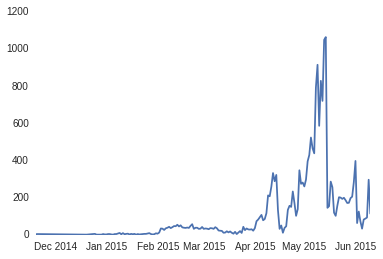

In [61]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
adShows_uniq_only['created_at'].apply(get_date).apply(datetime.datetime.date).value_counts().sort_index().plot()

In [65]:
adShows_uniq_only_small_dropna = adShows_uniq_only_small.dropna(axis=0)

In [66]:
adShows_uniq_only_small_dropna.shape

(4142, 20)

In [71]:
def get_browser(br_vs):
    return br_vs.split()[0]
adShows_uniq_only_small_dropna.loc[:, 'br'] = adShows_uniq_only_small_dropna.loc[:, 'br'].apply(get_browser)

In [72]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
adShows_uniq_only_small_dropna.loc[:, 'created_at'] = adShows_uniq_only_small_dropna.loc[:, 'created_at'].apply(get_date)

In [73]:
def get_time_of_day(datetimeObj):
    hour = datetimeObj.hour
    result = 'Evening'
    if hour < 12:
        result = 'Morning'
    elif hour < 16:
        result = 'Afternoon'
    return result
adShows_uniq_only_small_dropna['time'] = adShows_uniq_only_small_dropna['created_at'].apply(get_time_of_day)

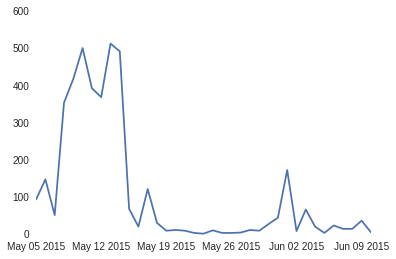

In [76]:
adShows_uniq_only_small_dropna['date'] = adShows_uniq_only_small_dropna['created_at'].apply(datetime.datetime.date)
adShows_uniq_only_small_dropna['date'].value_counts().sort_index().plot()

In [77]:
negative1 = pd.concat([pd.get_dummies(adShows_uniq_only_small_dropna['br'],prefix='br'),pd.get_dummies(adShows_uniq_only_small_dropna['co'],prefix='co'),pd.get_dummies(adShows_uniq_only_small_dropna['cty'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')),prefix='cty'),pd.get_dummies(adShows_uniq_only_small_dropna['rgn'],prefix='rgn'),pd.get_dummies(adShows_uniq_only_small_dropna['time'],prefix='time'),pd.get_dummies(adShows_uniq_only_small_dropna['dt'],prefix='dt'),pd.get_dummies(adShows_uniq_only_small_dropna['plfm'],prefix='plfm'),pd.get_dummies(adShows_uniq_only_small_dropna['isp'],prefix='isp'),pd.get_dummies(adShows_uniq_only_small_dropna['ssp'],prefix='ssp'),adShows_uniq_only_small_dropna[['dp','ernc','cr','li','lidp','pbep','sdpt','vw_drtn','vw_perc','created_at']]],axis=1)
negative1.shape

(4142, 2039)

It seems that the major differences are in country (co), city, regrion, and isp

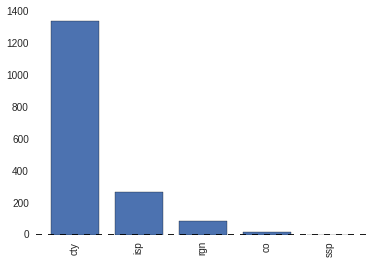

In [264]:
positive1_ids = pd.Series(positive1.columns)
negative1_ids = pd.Series(negative1.columns)
negative1_ids[negative1_ids.apply(lambda x: x in (set(negative1_ids) - set(positive1_ids)))].apply(lambda x: x.split('_')[0]).value_counts().plot(kind='bar')

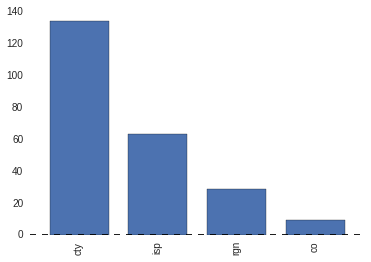

In [263]:
positive1_ids[positive1_ids.apply(lambda x: x in (set(positive1_ids) - set(negative1_ids)))].apply(lambda x: x.split('_')[0]).value_counts().plot(kind='bar')

In [78]:
positive1['click'] = 1
negative1['click'] = 0

Positive1: 1082 x 554

Negative1: 4142 x 2040

shared features: 319

unique features: Positive1 - 235; Negative1 - 1721

If doing outer join, I should get a new dataframe with size 5224 x 2275

In [79]:
data1 = pd.concat([positive1,negative1], axis=0, join='outer')

In [80]:
data1.shape

(5224, 2275)

Filling the missing values here with 0s - boolean false

In [81]:
data1 = data1.fillna(0)

#Prepare for training set for machine learning

Use time to split the data

Data1: 5/5/15 - 6/9/15

Split the data:
Training: 5/5 - 5/25
Validation: 5/26 - 6/1
Test: 6/2 - 6/9

In [82]:
train1 = data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day < 26), :]
train1.shape

(4420, 2275)

In [83]:
validate1 = data1.loc[data1['created_at'].apply(lambda x: ((x.month == 5 and x.day > 25) or (x.month == 6 and x.day < 2))), :]
validate1.shape

(408, 2275)

In [84]:
test1 = data1.loc[data1['created_at'].apply(lambda x: x.month == 6 and x.day > 1), :]
test1.shape

(396, 2275)

In [282]:
train1['click'].value_counts()

0    3651
1     769
dtype: int64

In [283]:
validate1['click'].value_counts()

0    284
1    124
dtype: int64

In [284]:
test1['click'].value_counts()

0    207
1    189
dtype: int64

The click-through-rate seems to be increasing over time...

In [289]:
train1.dtypes[train1.dtypes.map(lambda x: x=='object')]

Series([], dtype: object)

In [85]:
click = train1['click'].values

In [86]:
train1 = train1.drop(['created_at','click'], axis=1) 

In [87]:
train1_data = train1.values

# Random forest classifier

In [88]:
forest = RandomForestClassifier(n_estimators = 100)

In [89]:
forest = forest.fit(train1_data,click)

In [90]:
click_validate = validate1['click'].values

In [91]:
validate1_data = validate1.drop(['created_at','click'], axis=1).values

In [92]:
predict1 = forest.predict(validate1_data)

In [93]:
click_validate

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [94]:
predict1

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [95]:
len(validate1)

408

Accuracy on validation set:

In [260]:
float(np.sum(click_validate == predict1))/len(validate1)

0.8529411764705882

Baseline:

In [319]:
float(np.sum(click_validate == 0))/len(validate1)

0.696078431372549

Precision "P" (TP / TP + FP):

In [323]:
float(np.sum((click_validate == 1)*(click_validate == predict1)))/np.sum(predict1 == 1)

0.9859154929577465

Recall "R" (TP / TP + FN):

In [324]:
float(np.sum((click_validate == 1)*(click_validate == predict1)))/np.sum(click_validate == 1)

0.5645161290322581

F_1 score (2PR/P+R):

In [325]:
2*0.5645161290322581*0.9859154929577465/(0.9859154929577465 + 0.5645161290322581)

0.7179487179487181

In [96]:
def error_analysis(predict, reality):
    precision = float(np.sum((reality == 1)*(reality == predict)))/np.sum(predict == 1)
    recall = float(np.sum((reality == 1)*(reality == predict)))/np.sum(reality == 1)
    f1score = 2*precision*recall/(precision + recall)
    return [precision, recall, f1score]
error_analysis(predict1, click_validate)

[0.9324324324324325, 0.5564516129032258, 0.6969696969696969]

Training error:

In [97]:
predict_train1 = forest.predict(train1_data)

In [98]:
error_analysis(predict_train1, click)

[0.9987012987012988, 1.0, 0.9993502274204028]

Training accuracy is amazing - sign of overfitting (high variace)?

# Feature importances (default: gini)

In [99]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Top 15 features:

(0, 0.2)

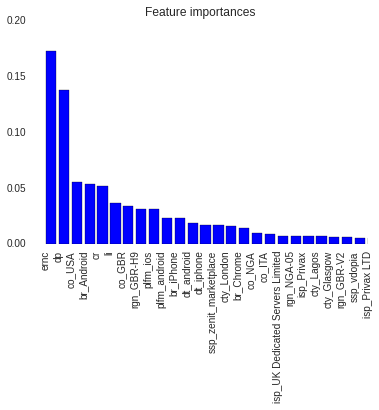

In [285]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],color="b")
plt.xticks(range(len(importances)), train1.columns[indices], rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0, 0.2])
#plt.savefig("../fig/20150610_RF_feature_top_30.png",format='png')

Least important features?

(-1e-05, 0)

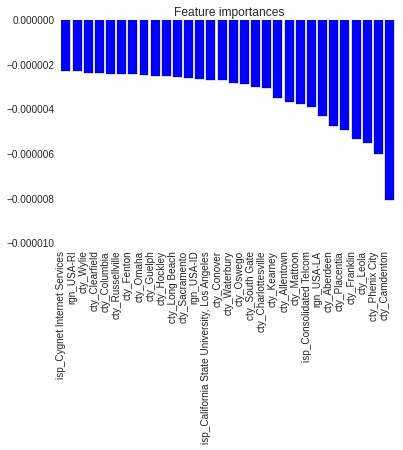

In [279]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],color="b")
plt.xticks(range(len(importances)), train1.columns[indices], rotation='vertical')
plt.xlim([2243, 2273])
plt.ylim([-0.00001, 0])

Combine the importance of features from the same category

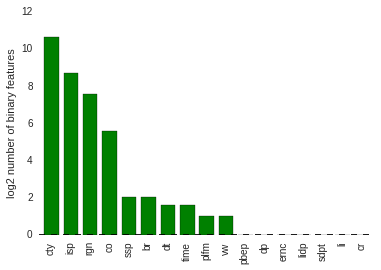

In [114]:
p = pd.value_counts(pd.Series([x.split('_')[0] for x in train1.columns.values])).apply(np.log2).plot(kind='bar',color='g')
p.set_ylabel('log2 number of binary features')
fig = p.get_figure()
fig.savefig('../fig/20150610_RF_feature_count.png',format='png')

Explore time dependence

In [129]:
features = pd.DataFrame({'feature': train1.columns.values, 'importance': importances, 'type': [x.split('_')[0] for x in train1.columns.values]}, index = range(len(importances)))

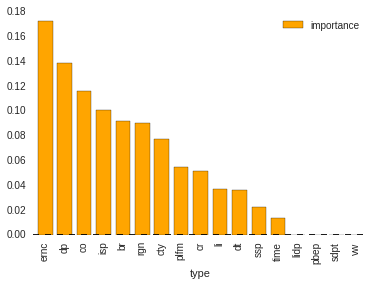

In [143]:
p = features[['type','importance']].groupby('type').sum().sort('importance', ascending = 0).plot(kind='bar',color='orange')
fig = p.get_figure()
fig.savefig('../fig/20150610_RF_feature_sum.png',format='png')

#Time dependence

The low recall rate here is largely due to the uneven 1/0 between the training and validation set, which means that CTR changes over time.

Per week: 5/5-11, 12-18, 19-25, 5/26-6/1, 2-8

In [151]:
click_cnt = pd.DataFrame({'5/05-5/11': data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day < 12), :]['click'].value_counts(),'5/12-5/18': data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day > 11 and x.day < 19), :]['click'].value_counts(),'5/19-5/25': data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day > 18 and x.day < 26), :]['click'].value_counts(),'5/26-6/1': data1.loc[data1['created_at'].apply(lambda x: ((x.month == 5 and x.day > 25) or (x.month == 6 and x.day < 2))), :]['click'].value_counts(),'6/2-6/8': data1.loc[data1['created_at'].apply(lambda x: x.month == 6 and x.day > 1 and x.day < 9), :]['click'].value_counts()})

In [160]:
click_cnt = click_cnt.transpose()

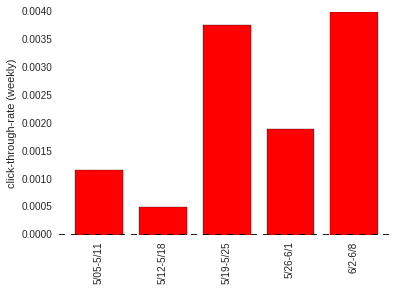

In [243]:
p = (click_cnt[1]/(click_cnt[1] + (click_cnt[0] * 4584942 / 20000))).plot(kind='bar',color='r')
p.set_ylabel('click-through-rate (weekly)')
fig = p.get_figure()
fig.savefig('../fig/20150610_CTR_by_week.png',format='png')

Look at longer period of time, maybe by month from the beginning?

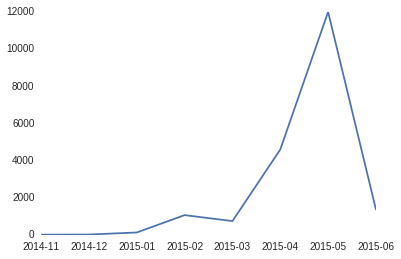

In [257]:
def get_year_month(timestring):
    mytime = timestring.split('.')[0]
    mydate = datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
    return '%s-%02d' % (mydate.year, mydate.month)
adShows_uniq_only['created_at'].apply(get_year_month).value_counts().sort_index().plot()

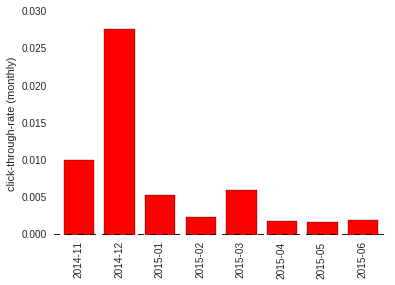

In [258]:
adShows_per_month = adShows_uniq['created_at'].apply(get_year_month).value_counts().sort_index()
# I do not need to exclude click events here
clicks_per_month = clicks_uniq['created_at'].apply(get_year_month).value_counts().sort_index()
ad_per_month = pd.DataFrame({'show': adShows_per_month, 'click': clicks_per_month})
ad_per_month['CRT'] = (ad_per_month['click'].T / (ad_per_month['show'].T * 4584942 / 20000)).T
p = ad_per_month['CRT'].plot(kind='bar',color='r')
p.set_ylabel('click-through-rate (monthly)')
fig = p.get_figure()
fig.savefig('../fig/20150611_CTR_by_month.png',format='png')

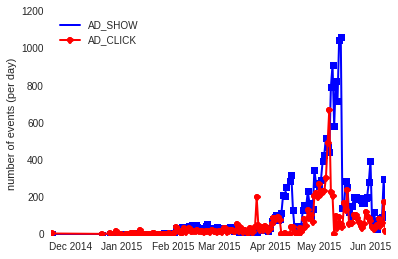

In [259]:
adShows_per_day = adShows_uniq['created_at'].apply(get_date).apply(datetime.datetime.date).value_counts().sort_index()
clicks_per_day = clicks_uniq['created_at'].apply(get_date).apply(datetime.datetime.date).value_counts().sort_index()
ad_per_day = pd.concat([adShows_per_day, clicks_per_day], axis=1, join='inner')
ad_per_day.columns = ['show', 'click']
p = ad_per_day['show'].plot(style='bs-', lw=2, label='AD_SHOW');
p.legend(loc = 'upper left')
ad_per_day['click'].plot(style='ro-', lw=2, label='AD_CLICK', ax=p);
p.set_ylabel('number of events (per day)')
fig = p.get_figure()
fig.savefig('../fig/20150611_event_by_day.png',format='png')

In [375]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
data2['created_at'] = data2['created_at'].apply(get_date)

In [350]:
rate = float(data3.click.sum())/data3.shape[0]
rate

0.28434065934065933

#Examine each important feature

How CTR varies across different categories of each feature?

#Browser: Android has higher CTR than iPhone

br_Android                                                       
br_Chrome                                                        
br_iPad                                                          
br_iPhone                                                        

Ploting the log relative CTR for each browser type:

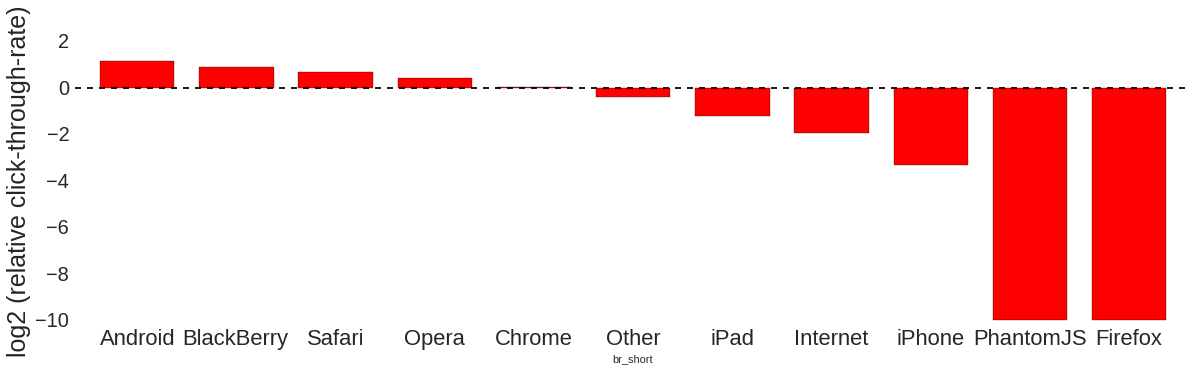

In [495]:
plt.figure(figsize=(20,5))
p = br_ctr.plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150612_CTR_by_br_sort.png',format='png')

Just as a reference, I also plotted the number of events in each category:

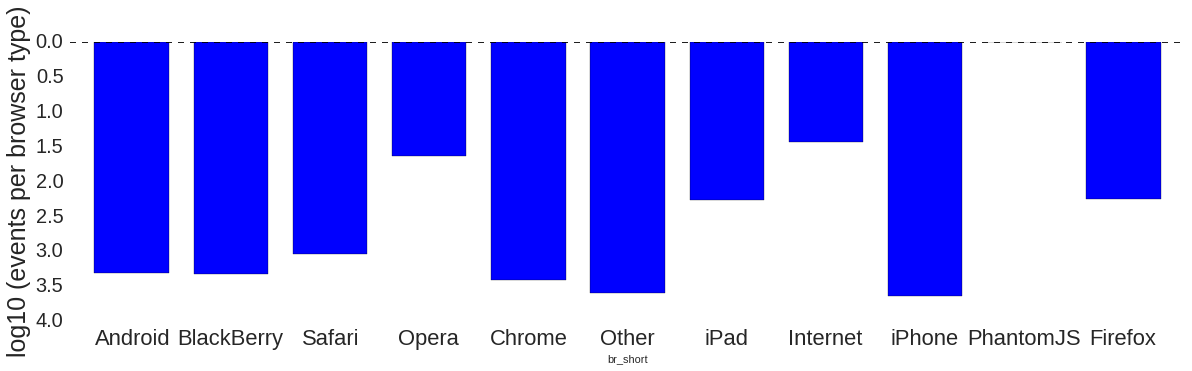

In [496]:
br_counts = data3['br_short'].value_counts()
plt.figure(figsize=(20,5))
p = np.log10(br_counts[br_ctr.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per browser type)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150612_et_by_br_sort.png',format='png')

# platform: android has higher CTR than iOS - consistent with browser

In [497]:
data3['plfm'].value_counts()

ios        4624
android    4025
dtype: int64

In [498]:
data3.groupby('plfm').apply(lambda x:float(x.click.sum())/x.shape[0]/rate)

plfm
android    1.729183
ios        0.133862
dtype: float64

# platform version also makes a difference

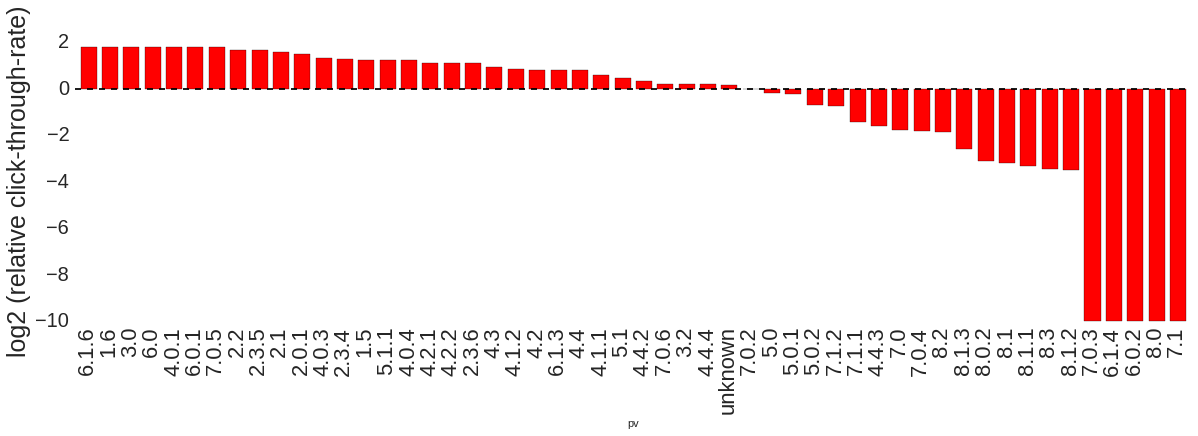

In [503]:
pv_ctr = data3.groupby('pv').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001))
pv_ctr.sort(ascending = False)
plt.figure(figsize=(20,5))
p = pv_ctr.plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150612_CTR_by_pv_sort.png',format='png')

Combine platform and platform version

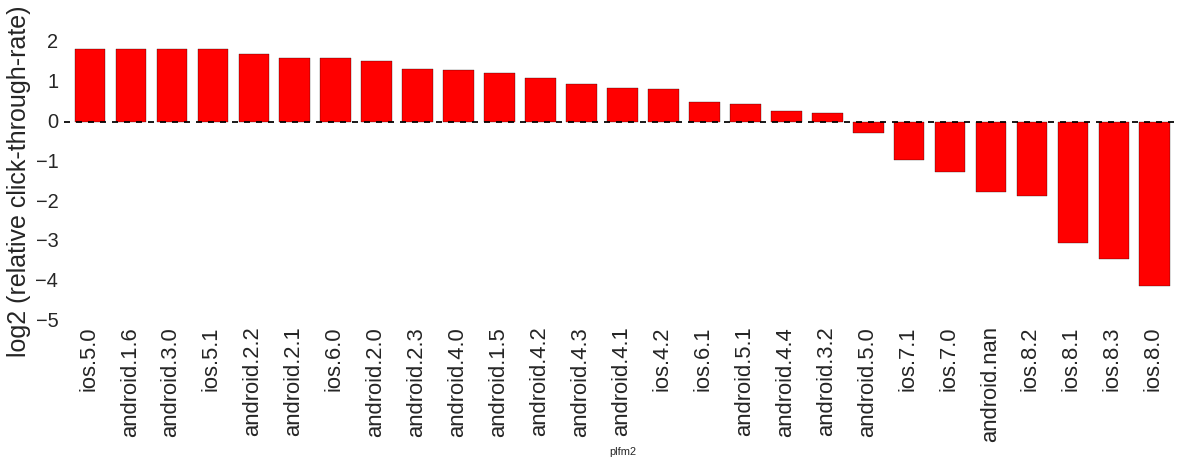

In [521]:
data3.loc[:,'plfm2'] = data3['plfm'] + '.' + data3['pv'].apply(lambda x: str.join('.',str(x).split('.')[:2]))
plfm2_ctr = data3.groupby('plfm2').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001))
plfm2_ctr.sort(ascending = False)
plt.figure(figsize=(20,5))
p = plfm2_ctr.plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150612_CTR_by_plfm_pv_sort.png',format='png')

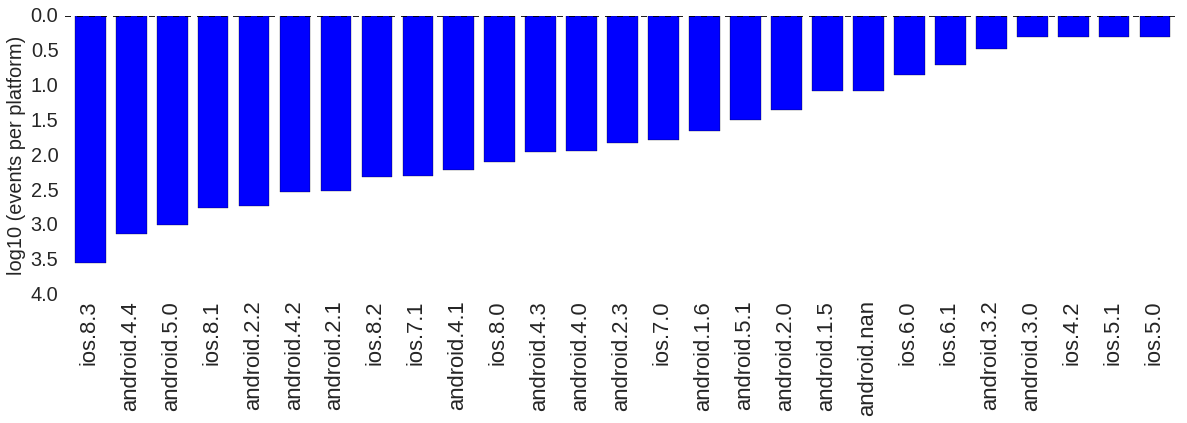

In [525]:
plfm2_counts = data3['plfm2'].value_counts()
plt.figure(figsize=(20,5))
p = np.log10(plfm2_counts[plfm2_counts.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per platform)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150612_et_by_plfm_pv_sort.png',format='png')

# 'ernc' and 'dp' - important for classification but hard to explain

In [382]:
float(data3[data3['ernc'].apply(lambda x:x < 50000)].click.sum())/data3[data3['ernc'].apply(lambda x:x < 50000)].shape[0]

0.12481741162722758

In [385]:
breaks = range(0,1400000,50000)
ernc_rates = []
for i in breaks:
    ernc_rates.append(float(data3[data3['ernc'].apply(lambda x:x < i)].click.sum())/(data3[data3['ernc'].apply(lambda x:x < i)].shape[0] + 0.000001))

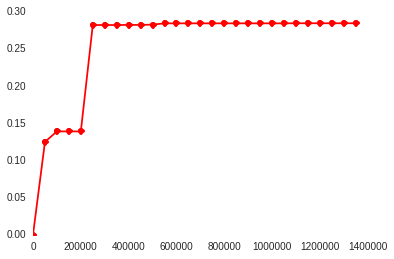

In [388]:
plt.plot(breaks, ernc_rates, 'ro-')

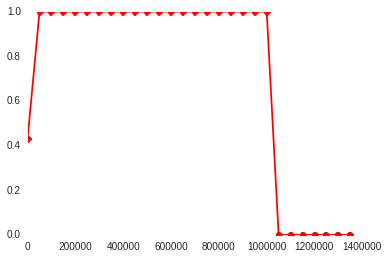

In [389]:
ernc_rates2 = []
for i in breaks:
    ernc_rates2.append(float(data3[data3['ernc'].apply(lambda x:x > i)].click.sum())/(data3[data3['ernc'].apply(lambda x:x > i)].shape[0] + 0.000001))
plt.plot(breaks, ernc_rates2, 'ro-')

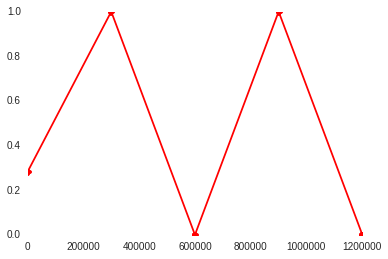

In [396]:
breaks2 = range(0,1500000,300000)
ernc_rates3 = []
for i in breaks2:
    ernc_rates3.append(float(data3[data3['ernc'].apply(lambda x:(x >= i and x < i + 300000))].click.sum())/(data3[data3['ernc'].apply(lambda x:(x >= i and x < i + 300000))].shape[0] + 0.000001))
plt.plot(breaks2, ernc_rates3, 'ro-')

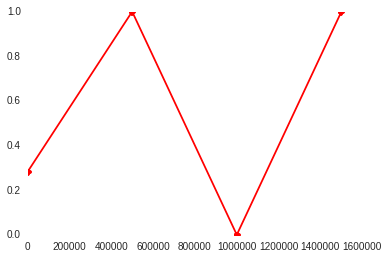

In [400]:
breaks3 = range(0,2000000,500000)
dp_rates = []
for i in breaks3:
    dp_rates.append(float(data3[data3['dp'].apply(lambda x:(x >= i and x < i + 500000))].click.sum())/(data3[data3['dp'].apply(lambda x:(x >= i and x < i + 500000))].shape[0] + 0.000001))
plt.plot(breaks3, dp_rates, 'ro-')

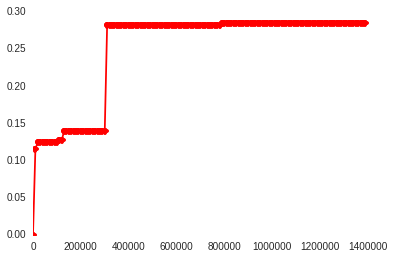

In [418]:
breaks3 = range(0,1400000,10000)
dp_rates = []
for i in breaks3:
    dp_rates.append(float(data3[data3['dp'].apply(lambda x:x < i)].click.sum())/(data3[data3['dp'].apply(lambda x:x < i)].shape[0] + 0.000001))
plt.plot(breaks3, dp_rates, 'ro-')

# Geolocation - country also has huge difference

In [412]:
co_counts = data3['co'].value_counts().sort_index()
co_rel_ctr = data3.groupby('co').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).sort_index()

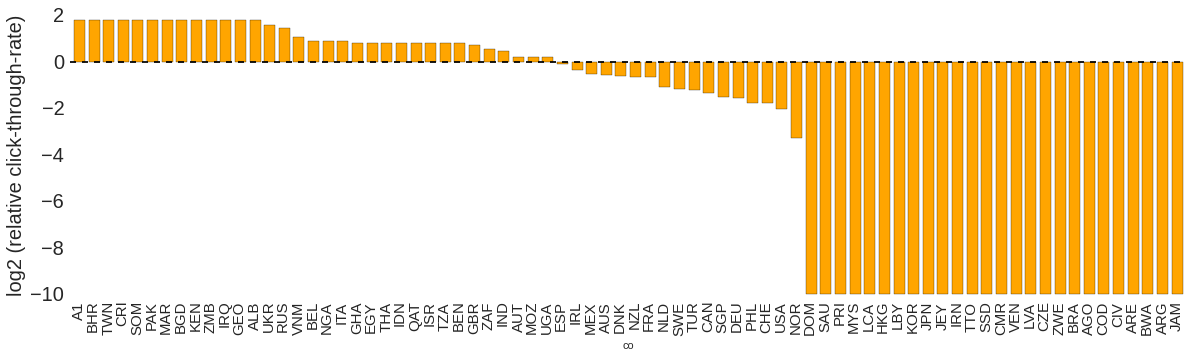

In [442]:
co_rel_ctr.sort(ascending = False)
plt.figure(figsize=(20,5))
p = co_rel_ctr.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=15)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150611_CTR_by_co_sort.png',format='png')

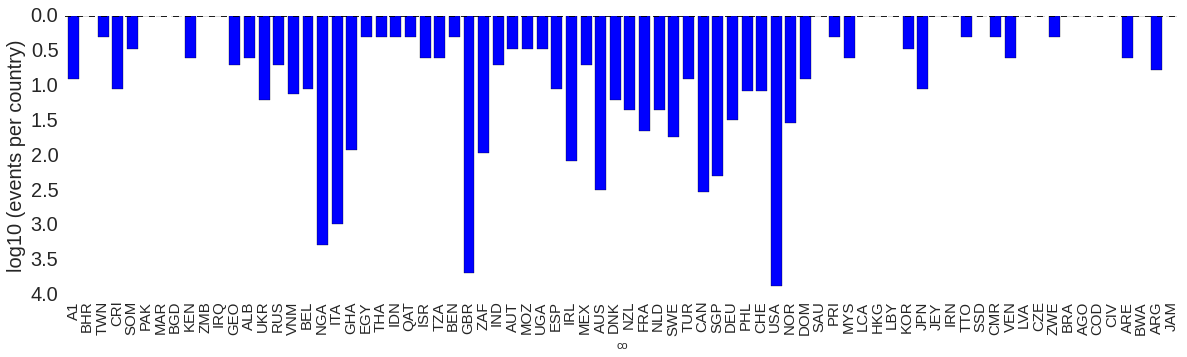

In [446]:
plt.figure(figsize=(20,5))
p = np.log10(co_counts[co_rel_ctr.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per country)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=15)
plt.setp(p.get_yticklabels(), fontsize=20)
plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150611_et_by_co_sort.png',format='png')

Try to show country variation by heat map

# Internet service provider also associates quite different CTR

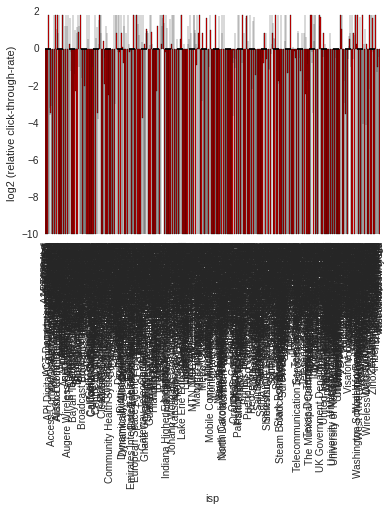

In [417]:
p = data3.groupby('isp').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)')
#fig = p.get_figure()
#fig.savefig('../fig/20150611_CTR_by_isp.png',format='png')

^ This is not very informative...

In [453]:
isp_ctr = data3.groupby('isp').apply(lambda x:float(x.click.sum())/x.shape[0]/rate)

In [456]:
len(isp_ctr)

826

In [460]:
isp_ctr_sort = isp_ctr[isp_ctr.apply(lambda x:x > 1)]

In [461]:
isp_ctr_sort.sort(ascending = False)

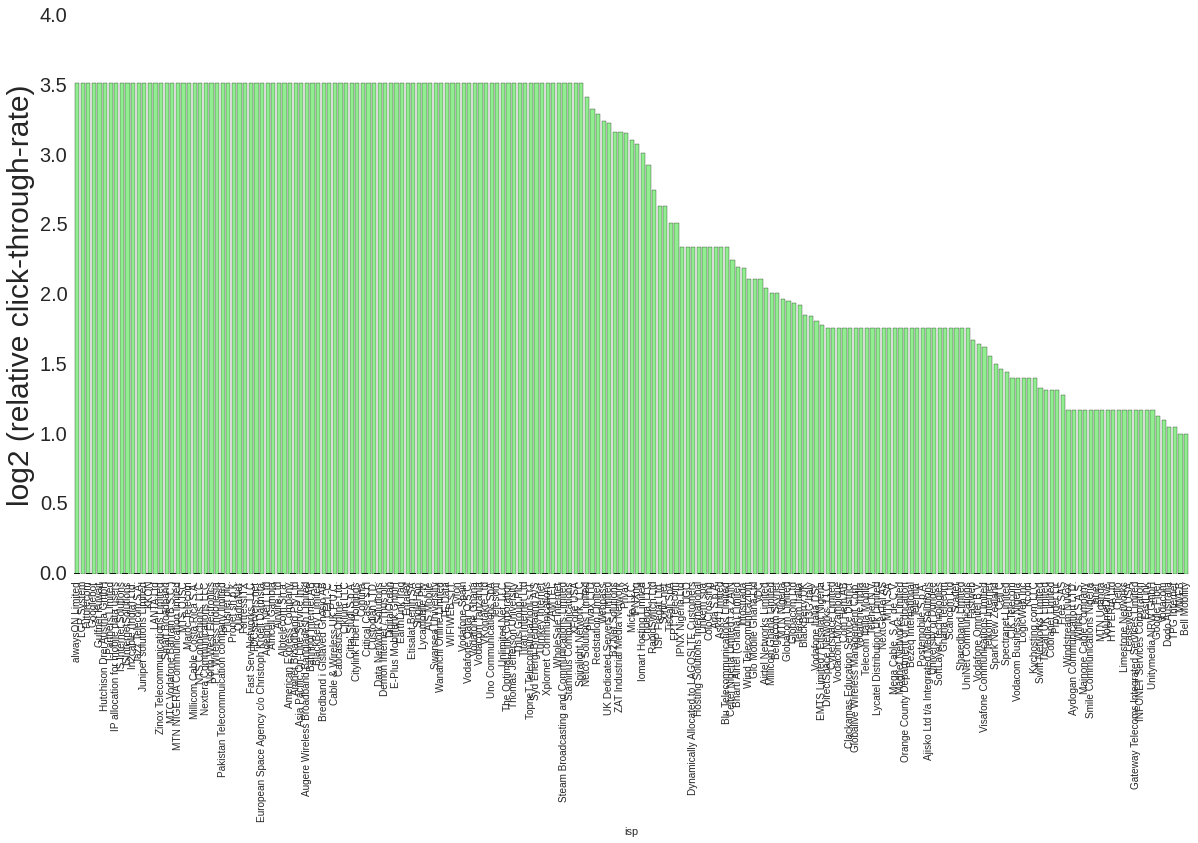

In [464]:
plt.figure(figsize=(20,10))
p = isp_ctr_sort.plot(kind='bar',color='lightgreen')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=30)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=10)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150611_CTR_by_isp_sort.png',format='png')

#Ads-app interaction

I noticed that CTR is very different from ad to ad, and from app to app. To look at the difference systematically, I generated a hierarchical clustered heatmap for CTR on each pair of ad-app.

In [ ]:
columns = [31,49,50,51,52,53,54,55,56,67,68,71,72,87,89,90,91,92,
           93,94,95,99,108,113,115,116,117,119,120,121,122,125,130,131,132,133,
           134,137,139,140,141,142,145]
index = [156, 157, 158, 169, 170, 171, 175, 190, 191, 192, 203, 204,
         205, 213, 214, 215, 216, 217, 218, 220, 221, 222, 225, 226, 227,
         228, 229, 230, 231, 232, 236, 237, 238, 239, 240, 241, 242, 243,
         245, 246, 248, 249, 250, 254, 256, 257, 258, 259, 261, 262, 263,
         264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
         277, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
         292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
         305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 318, 319,
         324, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
         339, 340, 341, 342, 343, 344, 346, 349, 350, 353]
df_show_m5 = pd.DataFrame(index=index, columns=columns)
df_show_m5 = df_show_m5.fillna(0)
for col in columns:
    for ind in index:
        df_show_m5.loc[ind,col] = es.count(index="events-2015.05.*",
                                           body={'query': {'bool': {'must':[{'match': { 'ai' : col }},
                                                                            {'match': { 'cr' : ind }},
                                                                            {'match': { 'et' : 'AD_SHOW' }}],
                                                                    'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
df_click_m5 = pd.DataFrame(index=index, columns=columns)
df_click_m5 = df_click_m5.fillna(0)
for col in columns:
    for ind in index:
        df_click_m5.loc[ind,col] = es.count(index="events-2015.05.*",
                                            body={'query': {'bool': {'must':[{'match': { 'ai' : col }},
                                                                             {'match': { 'cr' : ind }},
                                                                             {'match': { 'et' : 'AD_CLICK' }}],
                                                                     'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
df_show_m6 = pd.DataFrame(index=index, columns=columns)
df_show_m6 = df_show_m6.fillna(0)
for col in columns:
    for ind in index:
        df_show_m6.loc[ind,col] = es.count(index="events-2015.06.*",
                                           body={'query': {'bool': {'must':[{'match': { 'ai' : col }},
                                                                            {'match': { 'cr' : ind }},
                                                                            {'match': { 'et' : 'AD_SHOW' }}],
                                                                    'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
df_click_m6 = pd.DataFrame(index=index, columns=columns)
df_click_m6 = df_click_m6.fillna(0)
for col in columns:
    for ind in index:
        df_click_m6.loc[ind,col] = es.count(index="events-2015.06.*",
                                            body={'query': {'bool': {'must':[{'match': { 'ai' : col }},
                                                                             {'match': { 'cr' : ind }},
                                                                             {'match': { 'et' : 'AD_CLICK' }}],
                                                                     'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
df_show = df_show_m5 + df_show_m6
df_click = df_click_m5 + df_click_m6

In [3]:
df_show = pd.read_csv("../data/ad_show_count_150617.tab",sep='\t',index_col=0,encoding='utf-8')
df_click = pd.read_csv("../data/ad_click_count_150617.tab",sep='\t',index_col=0,encoding='utf-8')

In [4]:
df_ctr = df_click / (df_show + 0.01)

In [5]:
rate = float(df_click.sum().sum()) / df_show.sum().sum()
rate

0.0022219420518531678

In [6]:
df_ctr_lo = np.log2(df_ctr/rate + 0.01)

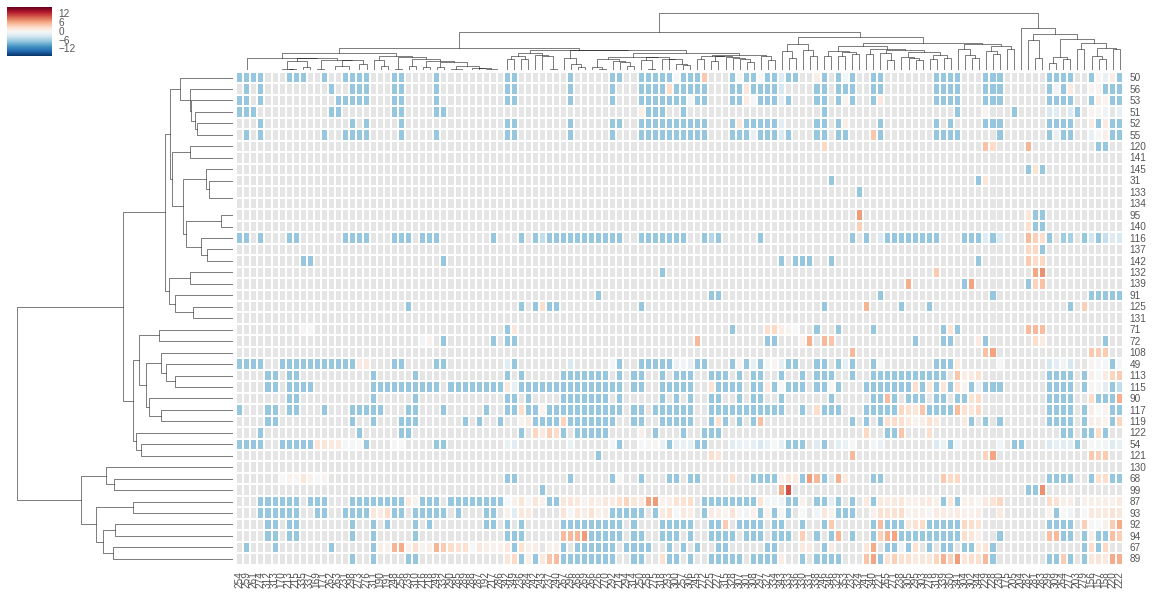

In [11]:
columns_c = ['50','56','53','51','52','55','120','141','145','31','133','134','95','140','116',
             '137','142','132','139','91','125','131','71','72','108','49','113','115','90','117',
             '119','122','54','121','130','68','99','87','93','92','94','67','89']
index_c = [254,259,261,274,312,313,170,213,215,335,337,169,171,262,263,
           231,298,273,276,311,190,191,248,256,239,310,216,218,249,332,
           290,285,289,288,287,192,217,286,342,349,236,284,242,243,237,
           240,267,296,268,269,266,226,270,292,214,294,314,250,258,275,
           318,293,300,257,306,245,272,225,227,315,328,307,301,308,297,
           327,334,343,333,336,330,331,338,246,346,329,353,232,324,241,
           340,221,265,271,238,305,295,303,278,319,339,350,341,304,302,
           344,229,228,230,175,205,204,282,281,283,299,309,264,277,203,
           279,156,157,158,220,222]
df_show_c = pd.DataFrame(index=index_c, columns=columns_c)
df_show_c = df_show_c.fillna(0)
for col in columns_c:
    for ind in index_c:
        df_show_c.loc[ind,col] = df_show.loc[ind,col]
mask = df_show_c.apply(lambda x: x == 0)
sns.clustermap(df_ctr_lo.T, figsize=(20, 10), mask=mask.T)

^The ads with historically bad performance need to be closely examined.

#Implement collaborative filtering

Idea: use ads performance on similar apps to make recommendations of new ads on a given app.

In [ ]:
import utils
df_ctr_dist = utils.cal_distances(df_ctr_lo3)
df_ctr_dist2 = df_ctr_dist[['common','euclidean','distance','cosine','pearson']]
df_ctr_dist2.index = pd.MultiIndex.from_arrays(df_ctr_dist[['app1','app2']].values.T)
df_ctr_lo_recal = utils.cal_scores(df=df_ctr_lo2,sm=df_ctr_dist2)
for app in df_ctr_lo2.columns:
    print app, utils.ads_recommendation(df_old=df_ctr_lo2,df_new=df_ctr_lo_recal2,app=app).index.values